In [1]:
# pip install Path   # Environment : conda activate pyclass   

In [1]:
import numpy as np ; import matplotlib as mpl ; import matplotlib.pyplot as plt ; import pandas as pd
import flopy ; from flopy.plot import styles;  from pathlib import Path; import os 
exe_name_mf = 'E:\\15_REPOS\\00_BETAMI\\w10_______others\\bin\\mf2005.exe'
exe_name_mt = 'E:\\15_REPOS\\00_BETAMI\\w10_______others\\bin\\mt3d-usgs_1.1.0_64.exe'
current_directory = os.getcwd();  print(current_directory)

E:\15_REPOS\00_BETAMI\98_Random\01_Mnfienen\C_USGS_2024


In [2]:
output_folder = Path('03-output') ; output_folder.mkdir(exist_ok=True)

In [3]:
%%capture
sim_ws = Path('data/pleasant-lake/')
sim = flopy.mf6.MFSimulation.load('pleasant', sim_ws=str(sim_ws), exe_name='mf6',)
sim.model_names          ; m = sim.get_model('pleasant')       ; m.modelgrid.epsg = 3070  ; m.modelgrid.units  ; m.modelgrid

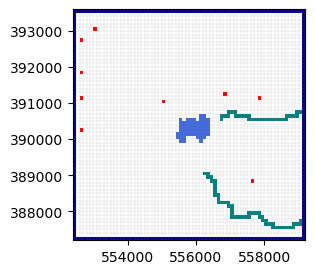

In [5]:
fig, ax = plt.subplots(figsize=(3, 3))  ; pmv = flopy.plot.PlotMapView(m, ax=ax)  ; lc = pmv.plot_grid(lw=0.1)
pmv.plot_bc("WEL", plotAll=True)  ; pmv.plot_bc("LAK", plotAll=True)  ; pmv.plot_bc("SFR", plotAll=True)  ;  pmv.plot_bc("CHD", plotAll=True)  

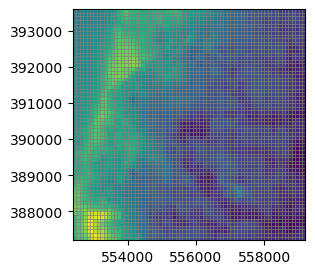

In [6]:
fig, ax=plt.subplots(figsize=(3, 3)) ; pmv=flopy.plot.PlotMapView(m,ax=ax) ; lc=pmv.plot_grid(lw=0.5) ; top=pmv.plot_array(m.dis.top.array)

### Exporting the model grid to a shapefile

In [7]:
m.modelgrid.write_shapefile(str(output_folder / 'pleasant_grid.shp'))

No CRS information for writing a .prj file.
Supply an valid coordinate system reference to the attached modelgrid object or .export() method.


Text(0, 0.5, 'Elevation, in Meters')

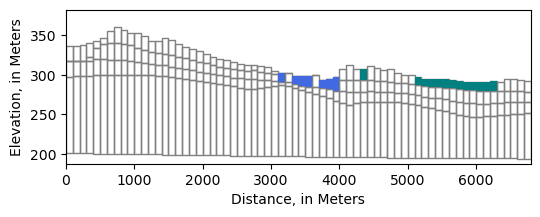

In [8]:
fig, ax = plt.subplots(figsize=(6, 2))         ; xs = flopy.plot.PlotCrossSection(model=m, line={"row": 30}, ax=ax)
lc = xs.plot_grid()  ; xs.plot_bc("LAK")  ; xs.plot_bc("SFR")
ax.set_xlabel(f'Distance, in {m.modelgrid.units.capitalize()}')  ; ax.set_ylabel(f'Elevation, in {m.modelgrid.units.capitalize()}')

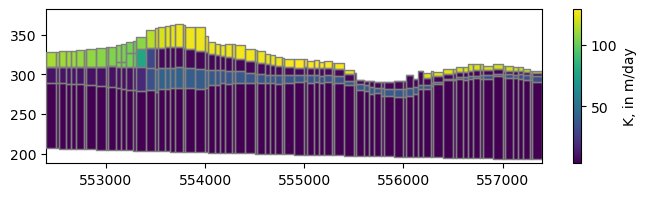

In [9]:
fig, ax = plt.subplots(figsize=(8, 2))           ; xs_line = [(552400, 393000), (552400 + 5000, 393000 - 4000)]
xs = flopy.plot.PlotCrossSection(model=m, line={"line": xs_line}, ax=ax, geographic_coords=True)
lc = xs.plot_grid(zorder=4) ; pc = xs.plot_array(m.npf.k.array)  ; fig.colorbar(pc, label='K, in m/day');

#### What if we want to look at cross sections for each row or column?
This code allows for every row or column to be visualized in cross section within the Jupyter Notebook session.

In [10]:
rec = m.rcha.recharge.array ;   print(rec.shape)

(13, 1, 64, 68)


Text(0.5, 0, 'Model stress period')

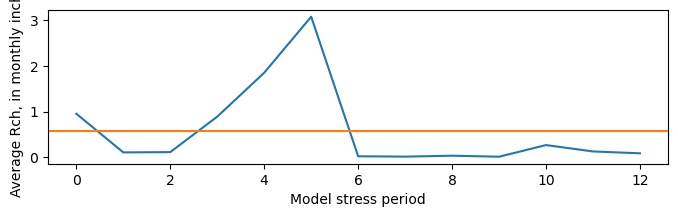

In [11]:
rch_inches = m.rcha.recharge.array[:, 0, :, :].mean(axis=(1, 2)) * 12 * 30.4 / .3048 
fig, ax = plt.subplots(figsize=(8, 2))  ; ax.plot(rch_inches)  ; ax.axhline(rch_inches.mean(), c='C1')
ax.set_ylabel(f"Average Rch, in monthly inches")          ; ax.set_xlabel("Model stress period")

#### Tabular data example: plot pumping by stress period
Most tabular input for the 'basic' stress packages (Constant Head, Drain, General Head, RIV, WEL, etc) are accessible via a ``stress_period_data`` attribute.   
* To access the data, we have to call another ``.data`` attribute, which gives us a dictionary of ``recarray``s by stress period.  
* Any one of these can be converted to a ``pandas.DataFrame`` individually, or we can make a dataframe of all of them with a simple loop.

In [33]:
aa = m.wel.stress_period_data.get_dataframe().items() ; aa # ; pd.DataFrame(aa)

dict_items([(0,    cellid_layer  cellid_row  cellid_column         q         boundname
0             2          24              2 -396.8670   pleasant_2-13-2
1             2          17              2 -409.9000    pleasant_2-9-2
2             3          23             44    0.0000  pleasant_3-12-23
3             3          25             26    0.0000  pleasant_3-13-14
4             3          24             54 -878.6540  pleasant_3-13-28
5             3          33              2    0.0000   pleasant_3-17-2
6             3          47             52  -48.9226  pleasant_3-24-27
7             3           5              6 -248.6180    pleasant_3-3-4
8             3           8              2 -400.0610    pleasant_3-5-2), (1,    cellid_layer  cellid_row  cellid_column  q         boundname
0             2          24              2  0   pleasant_2-13-2
1             2          17              2  0    pleasant_2-9-2
2             3          23             44  0  pleasant_3-12-23
3           

In [34]:
dfs = []
for kper, df in m.wel.stress_period_data.get_dataframe().items():
    df['per'] = kper
    dfs.append(df)
df = pd.concat(dfs)  ; df

,cellid_layer,cellid_row,cellid_column,q,boundname,per
0,2,24,2,-396.867,pleasant_2-13-2,0
1,2,17,2,-409.900,pleasant_2-9-2,0
2,3,23,44,0.000,pleasant_3-12-23,0
3,3,25,26,0.000,pleasant_3-13-14,0
4,3,24,54,-878.654,pleasant_3-13-28,0
...,...,...,...,...,...,...
4,3,24,54,0.000,pleasant_3-13-28,10
5,3,33,2,0.000,pleasant_3-17-2,10
6,3,47,52,0.000,pleasant_3-24-27,10
7,3,5,6,0.000,pleasant_3-3-4,10


In [13]:
print(df.shape) ; sa = pd.DataFrame(df) ;  sa.to_csv (output_folder / "A1_Wells.csv")  ; print('Wells = ',sa.shape)

(81, 6)
Wells =  (81, 6)


Text(0.5, 0, 'Model stress period')

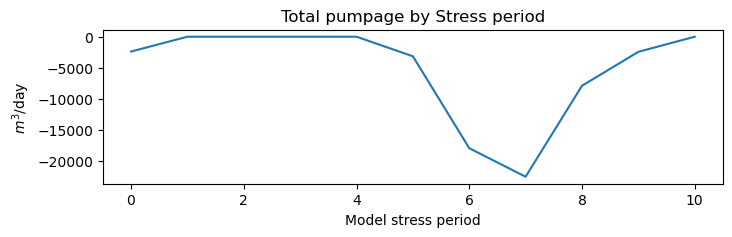

In [14]:
df.groupby('per').sum()['q'].plot(figsize=(8, 2))
plt.title('Total pumpage by Stress period')  ; plt.ylabel('$m^3$/day')  ; plt.xlabel('Model stress period')

Text(0, 0.5, 'm^3/day')

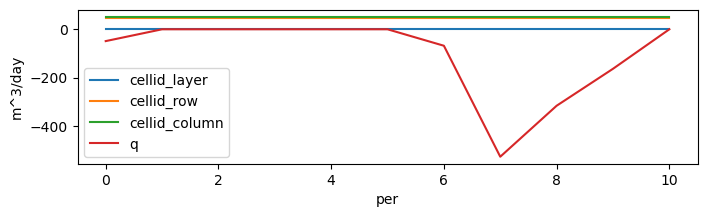

In [15]:
ax = df.groupby('boundname').get_group('pleasant_3-24-27').plot(x='per', figsize=(8, 2))   ; ax.set_ylabel('m^3/day')

In [16]:
sim.run_simulation(silent=True)

(True, [])

In [17]:
from flopy.utils.postprocessing import get_water_table
hds = m.output.head().get_data(kstpkper=(0, 0))   ;   wt = get_water_table(hds)    ; print('H =', hds.shape)

H = (4, 64, 68)


In [18]:
row = hds     [0] ; sa = pd.DataFrame(row) ;  sa.to_csv (output_folder / "A2_Heads_H0.csv")  ; print('A2_Heads_H0',sa.shape)

A2_Heads_H0 (64, 68)


In [19]:
lak_output = pd.read_csv(sim_ws / 'lake1.obs.csv')  ; stage   = lak_output['STAGE'][0]  
sa = pd.DataFrame(lak_output)  ;  sa.to_csv (output_folder / "A3_lak_output.csv")             ; print('A3_lak_output',sa.shape)

cnd = pd.DataFrame(m.lak.connectiondata.array)      ; k, i, j = zip( *cnd ['cellid'])  ; wt[i, j] = stage

sfr_stage = m.sfr.output.stage().get_data()[0, 0, :] 
sfr_k, sfr_i, sfr_j  = zip(*m.sfr.packagedata.array['cellid'])
wt [   sfr_i, sfr_j] = sfr_stage

cbc = m.output.budget()        ; lak = cbc.get_data(text='lak', full3D=True)[0].sum(axis=0)   ; sfr = cbc.get_data(text='sfr', full3D=True)[0]

A3_lak_output (13, 13)


In [20]:
print(wt.shape) ; sa = pd.DataFrame(wt) ;  sa.to_csv (output_folder / "A4_Lake_wt.csv")  

(64, 68)


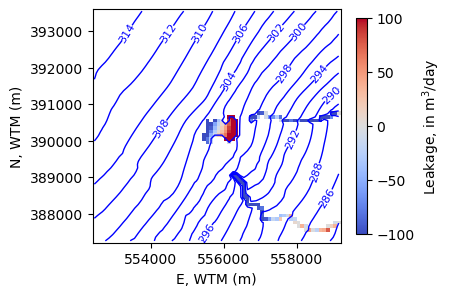

In [21]:
levels=np.arange(280, 315, 2)
fig, ax = plt.subplots(figsize=(4, 4)) ; pmv = flopy.plot.PlotMapView(m, ax=ax) ; ctr = pmv.contour_array(wt, levels=levels, linewidths=1, colors='b')
labels = pmv.ax.clabel(ctr, inline=True, fontsize=8, inline_spacing=1) ; vmin, vmax = -100, 100
im = pmv.plot_array(lak, cmap='coolwarm', vmin=vmin, vmax=vmax)
im = pmv.plot_array(sfr.sum(axis=0), cmap='coolwarm', vmin=vmin, vmax=vmax)
cb = fig.colorbar(im, shrink=0.7, label='Leakage, in m$^3$/day') ; ax.set_ylabel("N, WTM (m)") ; ax.set_xlabel("E, WTM (m)") ; ax.set_aspect(1)

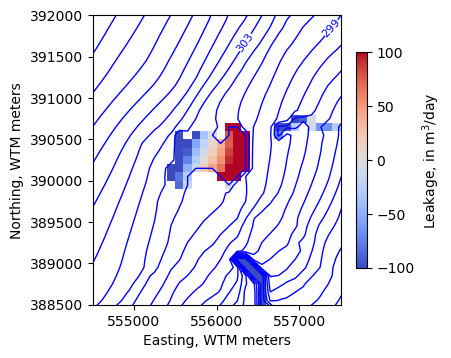

In [22]:
levels=np.arange(280, 315, 1)                                                     ; new_extent = (554500, 557500, 388500, 392000)
fig,ax = plt.subplots(figsize=(4,4)) ; pmv=flopy.plot.PlotMapView(m,ax=ax,extent = new_extent)          ; vmin, vmax = -100, 100
ctr = pmv.contour_array(wt, levels=levels, linewidths=1, colors='b') ; labels = pmv.ax.clabel(ctr, inline=True, fontsize=8, inline_spacing=1)
im = pmv.plot_array(lak, cmap='coolwarm', vmin=vmin, vmax=vmax)
im = pmv.plot_array(sfr.sum(axis=0), cmap='coolwarm', vmin=vmin, vmax=vmax)
cb = fig.colorbar(im, shrink=0.7, label='Leakage, in m$^3$/day')
ax.set_ylabel("Northing, WTM meters") ; ax.set_xlabel("Easting, WTM meters")  ; ax.set_aspect(1)

from flopy.export.utils import export_array
export_array(m.modelgrid, str(output_folder / 'water_table.tif'), wt)

(11.120818299999996, -76.35338698486248)

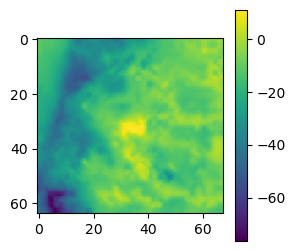

In [23]:
op = wt - m.dis.top.array    ; plt.figure(figsize=(3, 3), dpi=100)  ; plt.imshow(op); plt.colorbar()  ; op.max(), op.min()

Text(0, 0.5, 'Elevation, in Meters')

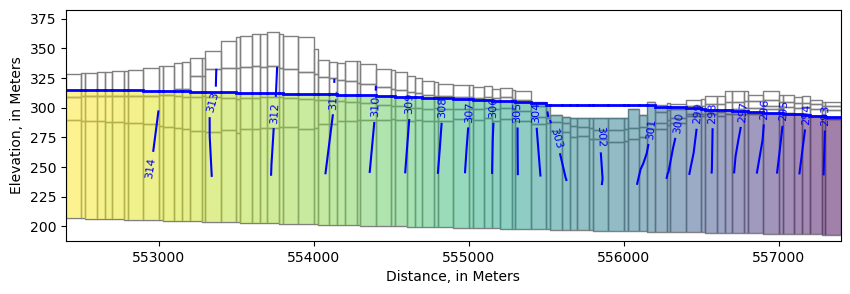

In [24]:
fig, ax = plt.subplots(figsize=(10, 3))                ; xs_line = [(552400, 393000), (552400 + 5000, 393000 - 4000)]
xs = flopy.plot.PlotCrossSection(model=m, line={"line" : xs_line}, ax=ax,geographic_coords=True)  #line={"row": 32},
lc  = xs.plot_grid()  ; pc = xs.plot_array(hds, head=hds, alpha=0.5, masked_values=[1e30])
ctr = xs.contour_array (hds, head=hds,  levels=levels,  colors="b",  masked_values=[1e30])
surf = xs.plot_surface(wt, masked_values=[1e30], color="blue", lw=2) ; labels = pmv.ax.clabel(ctr, inline=True, fontsize=8, inline_spacing=5)
ax.set_xlabel(f'Distance, in {m.modelgrid.units.capitalize()}') ; ax.set_ylabel(f'Elevation, in {m.modelgrid.units.capitalize()}')

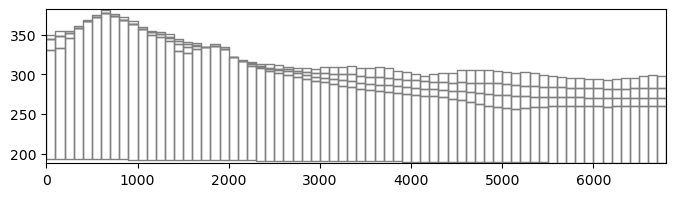

In [25]:
fig, ax = plt.subplots(figsize=(8, 2))   ; xs = flopy.plot.PlotCrossSection(model=m, line={"row": 62}, ax=ax)  ; lc = xs.plot_grid()

In [26]:
headobs = pd.DataFrame(m.obs_3.output.obs().get_data()) ;      # headobs  # m.get_package_list()    
headobs.to_csv (output_folder / "A5_OBS_3.csv")                # or   headobs = pd.read_csv(sim_ws / 'pleasant.head.obs')) 

### **Boundnames**

In [27]:
CHD_Bound = pd.read_csv(sim_ws  /  'external/chd_001.dat'  , delim_whitespace=True)
CHD_Bound.to_csv (output_folder /  "A6_CHD_Bound.csv") 
df        = pd.read_csv(sim_ws  /  'pleasant.chd.obs.output.csv')  ; df.index = df['time']  ;  # df.head()
df.to_csv        (output_folder /  "A7_Bound_2_ordered.csv")      # ModflowGwfchd(model, loading_

C:\Users\gross.DESKTOP-AIRQM2M\AppData\Local\Temp\ipykernel_7344\3531144793.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  CHD_Bound = pd.read_csv(sim_ws  /  'external/chd_001.dat'  , delim_whitespace=True)


In [28]:
from flopy.utils import Mf6ListBudget 

In [29]:
mfl = Mf6ListBudget(sim_ws    / 'pleasant.list')             ; flux,_vol = mfl.get_dataframes(start_datetime='2011-12-30')  ; 
flux,_vol.to_csv(output_folder / "A8_Q.csv")  ;  # flux.head()
# ax = flux['PERCENT_DISCREPANCY'].plot() ; ax.set_ylabel('Percent mass balance error')

Text(0, 0.5, 'Simulated Flux, in $m^3/d$')

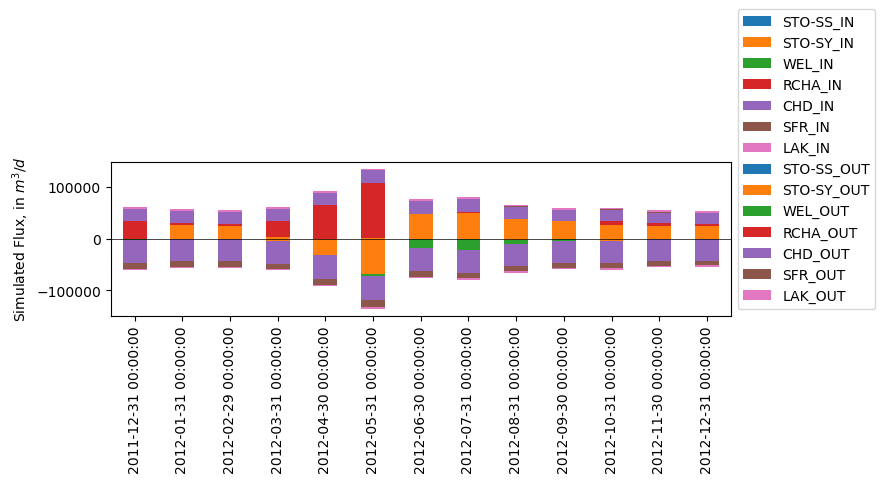

In [30]:
fig, ax  = plt.subplots(figsize=(8, 2))
in_cols  = ['STO-SS_IN', 'STO-SY_IN', 'WEL_IN', 'RCHA_IN', 'CHD_IN', 'SFR_IN', 'LAK_IN']  ; out_cols = [c.replace('_IN', '_OUT') for c in in_cols]
flux[in_cols].plot.bar(stacked=True, ax=ax)        ;    (-flux[out_cols]).plot.bar(stacked=True, ax=ax)
ax.legend(loc='lower left', bbox_to_anchor=(1, 0)) ; ax.axhline(0, lw=0.5, c='k') ;   ax.set_ylabel('Simulated Flux, in $m^3/d$')